Use a code-based LLM to help you set up the following:
1. Create a dataframe with a dependent variable of "passenger fare," and three independent variables of your choice.
2. Fit a linear regression model that predicts passenger fare from those three variables.

In [7]:
import warnings
warnings.filterwarnings('ignore', message='.*is_sparse is deprecated.*')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Load Titanic training data
raw_df = pd.read_csv('titanic/train.csv')


In [8]:
# Keep the dependent variable (Fare) and three predictors
model_df = raw_df[['Fare', 'Age', 'Pclass', 'Cabin']].copy()

# Quick look at the subset
model_df.head()

,Fare,Age,Pclass,Cabin
0,7.2500,22.0,3,NaN
1,71.2833,38.0,1,C85
2,7.9250,26.0,3,NaN
3,53.1000,35.0,1,C123
4,8.0500,35.0,3,NaN


In [9]:
X = model_df[['Age', 'Pclass', 'Cabin']]
y = model_df['Fare']

numeric_features = ['Age', 'Pclass']
categorical_features = ['Cabin']

preprocess = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]),
            numeric_features,
        ),
        (
            'cat',
            Pipeline(
                steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore')),
                ]
            ),
            categorical_features,
        ),
    ]
)

model = Pipeline(steps=[('preprocess', preprocess), ('regressor', LinearRegression())])
model.fit(X, y)

print('R^2 on training data:', model.score(X, y))

R^2 on training data: 0.7250487258833129


In [10]:
# Inspect learned coefficients for the linear regression
feature_names = model.named_steps['preprocess'].get_feature_names_out()
coefs = model.named_steps['regressor'].coef_
for name, coef in zip(feature_names, coefs):
    print(f"{name}: {coef:.4f}")

num__Age: -0.2056
num__Pclass: -23.2639
cat__Cabin_A10: -35.6630
cat__Cabin_A14: -25.4380
cat__Cabin_A16: -33.7124
cat__Cabin_A19: -51.4389
cat__Cabin_A20: -16.1762
cat__Cabin_A23: -36.7110
cat__Cabin_A24: -26.3233
cat__Cabin_A26: -36.1621
cat__Cabin_A31: -43.9631
cat__Cabin_A32: -27.4381
cat__Cabin_A34: -0.5299
cat__Cabin_A36: -75.1705
cat__Cabin_A5: -33.9133
cat__Cabin_A6: -41.9386
cat__Cabin_A7: -40.9664
cat__Cabin_B101: 436.3516
cat__Cabin_B102: -77.4398
cat__Cabin_B18: -19.0725
cat__Cabin_B19: -37.1306
cat__Cabin_B20: -21.2873
cat__Cabin_B22: -1.3152
cat__Cabin_B28: 7.0674
cat__Cabin_B3: 136.9997
cat__Cabin_B30: -7.8252
cat__Cabin_B35: -8.9868
cat__Cabin_B37: -41.5497
cat__Cabin_B38: -47.3817
cat__Cabin_B39: -29.1759
cat__Cabin_B4: -46.4172
cat__Cabin_B41: 8.3647
cat__Cabin_B42: -49.2955
cat__Cabin_B49: 12.3813
cat__Cabin_B5: 132.6440
cat__Cabin_B50: -46.1135
cat__Cabin_B51 B53 B55: 182.5467
cat__Cabin_B57 B59 B63 B66: 183.1685
cat__Cabin_B58 B60: 171.9173
cat__Cabin_B69: 21.0148


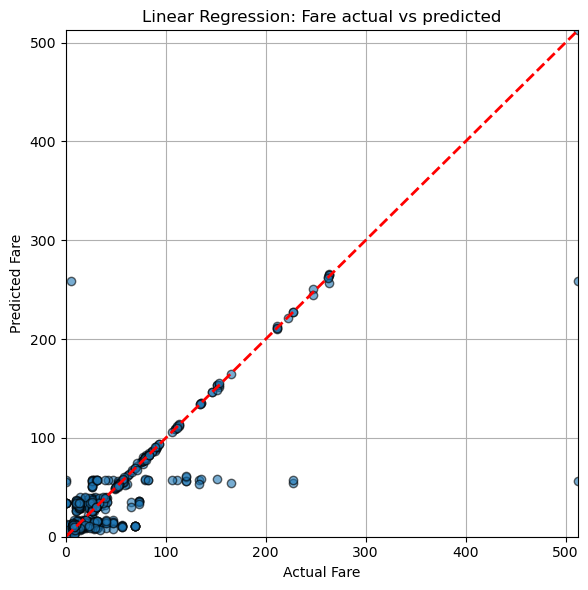

In [11]:
import matplotlib.pyplot as plt

# Predictions vs actuals plot with identity line
preds = model.predict(X)
lims = [min(y.min(), preds.min()), max(y.max(), preds.max())]

plt.figure(figsize=(6, 6))
plt.scatter(y, preds, alpha=0.6, edgecolor='k')
plt.plot(lims, lims, 'r--', linewidth=2)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Linear Regression: Fare actual vs predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


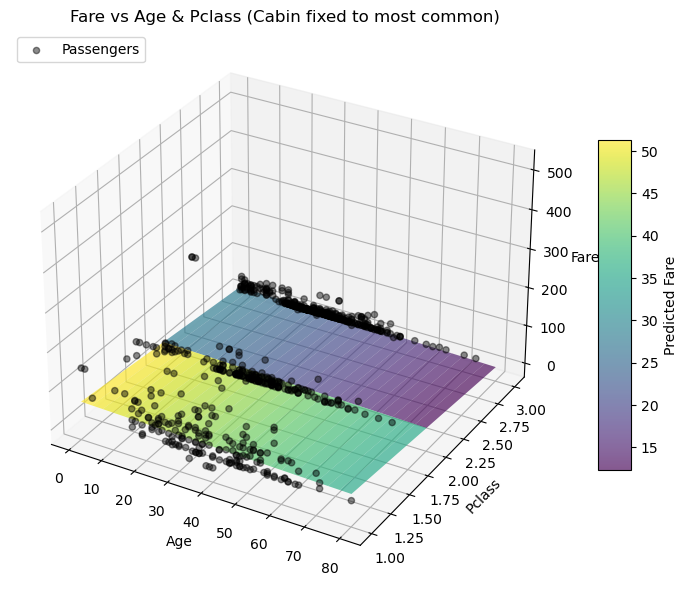

In [12]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 needed for 3D projection

# Use Age and Pclass as axes; fix Cabin at its mode to visualize the learned plane
plot_df = model_df[['Age', 'Pclass', 'Fare', 'Cabin']].dropna(subset=['Age', 'Pclass', 'Fare'])
mode_cabin = model_df['Cabin'].mode()[0] if not model_df['Cabin'].mode().empty else ''

age_vals = np.linspace(plot_df['Age'].min(), plot_df['Age'].max(), 25)
pclass_vals = sorted(plot_df['Pclass'].unique())
A_grid, P_grid = np.meshgrid(age_vals, pclass_vals)

flat = pd.DataFrame({
    'Age': A_grid.ravel(),
    'Pclass': P_grid.ravel(),
    'Cabin': mode_cabin,
})
Z = model.predict(flat).reshape(P_grid.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(plot_df['Age'], plot_df['Pclass'], plot_df['Fare'], color='k', alpha=0.45, label='Passengers')
surf = ax.plot_surface(A_grid, P_grid, Z, cmap='viridis', alpha=0.65, linewidth=0)

ax.set_xlabel('Age')
ax.set_ylabel('Pclass')
ax.set_zlabel('Fare')
ax.set_title('Fare vs Age & Pclass (Cabin fixed to most common)')
ax.legend(loc='upper left')
fig.colorbar(surf, shrink=0.6, aspect=10, label='Predicted Fare')
plt.tight_layout()
plt.show()

In [16]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("reg", LinearRegression())
])

# Fit and predict on the full dataset
model.fit(X, y)
y_pred = model.predict(X)

# Sum of Squared Residuals (SSR / SSE)
residuals = y - y_pred
ssr_full = float(np.sum(residuals ** 2))

print("SSR (full dataset):", ssr_full)


SSR (full dataset): 604287.4349530906
